# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
This tutorial uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

At the end of this tutorial the user will perform control co-design of the WEC geometry and a corresponding optimal controller to maximize electrical power. 
We build up to this problem in three parts of successive complexity:

1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules: 

* Import Autograd (wrapper on NumPy, required) for [automatic differentiation](https://sandialabs.github.io/WecOptTool/theory.html#automatic-differentiation)
* Import other packages we will use in this tutorial
* Import WecOptTool 

In [9]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')


## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem using WecOptTool.

The objective of this example is to **find the optimal PTO force time series** that produces the most mechanical power subject to the WEC dynamics and a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:

* The wave environment
* The WEC object, including all of its properties and constraints
* The objective function

The graphic below shows all the requirements for this first part of the tutorial: the wave environment on the left, the WEC object(with its relevant subcomponents) in the blue box in the middle, and the objective function (mechanical power) on the right.

<div>
<img src="https://live.staticflickr.com/65535/52435098523_37d6a2ca94_k.jpg" width="1000">
</div>

### Waves and WEC geometry
The pseudo-spectral solution used in WecOptTool requires a specified set of frequencies to analyze.
To model the WEC accurately, we need to ensure the set of selected frequencies captures the full hydrodynamic response range of the WEC.

Therefore, we start our WecOptTool model by defining this set of frequencies, the wave environment, and the mesh of the WEC geometry.
This ensures the minimum wavelength in the selected frequencies is larger than the minimum wavelength that can be analyzed with the mesh using the Boundary Element Method (BEM), which we will do [later](#bem-solution).
This is a good initial check to make sure the hydrodynamic properties results calculated with the BEM will be accurate.

#### Frequency selection
To start with a simple case in this tutorial, we are interested in modeling a regular wave at 0.3 Hz.
In regular waves, the linear WEC system response will always occur at the wave frequency, with the nonlinear system response also occurring at the corresponding odd harmonics (3rd, 5th, etc.) of the wave frequency.
Thus, we can set the fundamental frequency in our set, $f_1$, equal to the wave frequency.
Prior WaveBot analysis has found that the nonlinear dynamics are sufficiently captured with the 3rd, 5th, 7th, and 9th harmonics.
WecOptTool assumes the spacing between frequencies equals the magnitude of $f_1$. Therefore, we will model 10 frequencies to encompass these harmonics.

These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem.
See the [Theory](https://sandialabs.github.io/WecOptTool/theory.html) section of the WecOptTool documentation for more details on the pseudo-spectral problem formulation.

It is important to use the lowest number of frequencies possible while still maintaining accuracy in order to minimize degrees of freedom and computation time for the optimization solver.

In [10]:
wavefreq = 0.3 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

#### Waves
WecOptTool is configured to have the wave environment specified as a 2-dimensional `xarray.DataArray` containing the complex wave amplitudes (in meters), wave phases (in degrees), and directions (in degrees).
We will use an amplitude of 0.0625 meters, a phase of 30 degrees, and direction 0 for this tutorial.
The two coordinates are the radial frequency ``omega`` (in rad/s)  and the direction ``wave_direction`` (in radians).

The `xarray` package has a pretty steep learning curve, so WecOptTool includes the `waves` module containing more intuitive functions that create `xarray.DataArray` objects for different types of wave environments.
See the `xarray` documentation [here](https://docs.xarray.dev/en/latest/index.html) if you are interested in learning more about the package.
In this case, we will use the `wecopttool.waves.regular_wave` function with our wave frequency, amplitude, phase, and direction:

In [11]:
amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.
The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there.
Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.), click [here](https://pypi.org/project/meshio/) for the full list of compatible mesh file types.

-0.006212884173080459


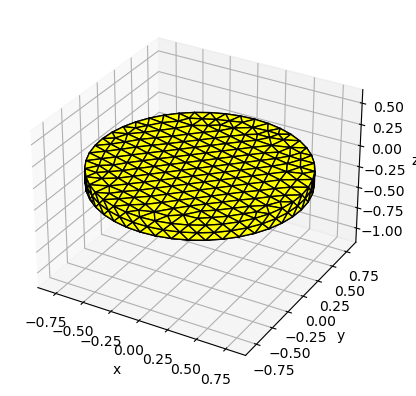

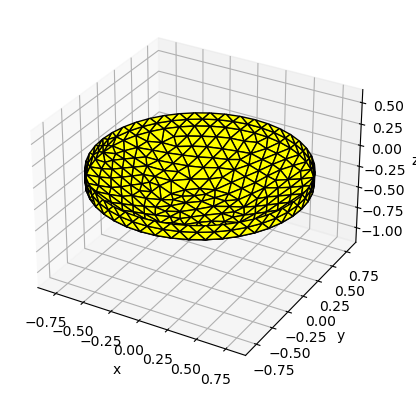

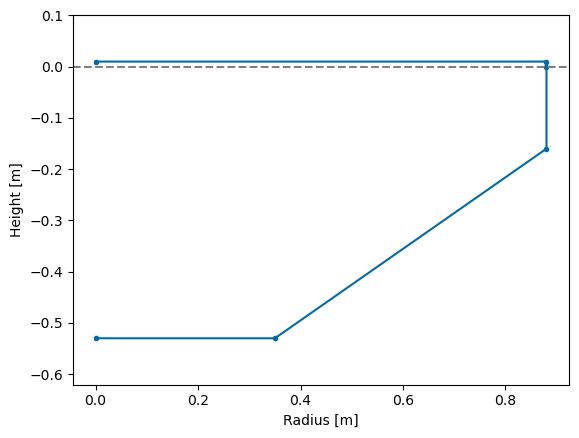

In [12]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object from wavebot
from capytaine.io.meshio import load_from_meshio
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_pos = mesh_obj.lowest_lid_position(omega_max=nfreq*f1*2*np.pi*2)
print(lid_pos)
lid_pos = -2e-2 # overwrite lid position
lid_mesh = mesh_obj.generate_lid(lid_pos)

fb = cpy.FloatingBody(mesh=mesh_obj, name="WaveBot")

fb.show_matplotlib()

fb.keep_immersed_part()

fb.show_matplotlib()
#fb.show()

_ = wb.plot_cross_section(show=True) # specific to WaveBot

We can also visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
These methods are interactive when used outside a Jupyter notebook.  
The included WaveBot example also has a method for plotting the cross-section of the device, `plot_cross_section`. 

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [13]:
min_computable_wavelength = fb.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

### WEC object
The `WEC` object in WecOptTool contains all the information about the WEC and its properties and dynamics.
This constitutes the vast majority of the setup required to run a WecOptTool optimization.
The WEC object handles three categoreis of data that are passed on to the optimizer:

1. The intrinsic impedance of the WEC
2. The WEC and PTO kinematic
3. The PTO dynamics

In order for the `WEC` object to be able to compute these data, we must provide information when we declare the object in the code.
The required information includes:

* [Degrees of freedom to consider](#degrees-of-freedom)
* [Linear hydrodynamic coefficients](#bem-solution)
* Any additional loads (e.g. PTO force, mooring, non-linear hydrodynamics)
* Device constraints

Again, we will keep things simple to start.
We will only consider heave motion and assume a lossless PTO, and the WaveBot has trivial WEC-PTO kinematics (unity).
We will apply one additional force (the PTO force on the WEC) and one constraint (the maximum PTO force), which [we define below using the PTO class](#pto).

#### Degrees of freedom
The degrees of freedom can be added directly to the `FloatingBody` using the `add_translation_dof` and `add_rotation_dof` methods. The axis of rotation is automatically defined if the method is supplied a name of `"Surge"`, `"Sway"`, `"Heave"`, `"Roll"`, `"Pitch"`, or `"Yaw"`. We will only model the heave degree of freedom in this case.

In [14]:
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

#### BEM solution

We can use the `FloatingBody` and frequency vector created earlier to run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object.
This is wrapped into the `wecopttool.run_bem` function.

If you would like to save the BEM data to a NetCDF file for future use, uncomment the second line of the cell below to use the `wot.write_netcdf` function.

In [15]:
bem_data = wot.run_bem(fb, freq)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file

[11:19:48] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

The resolution of the mesh might be insufficient for omega ranging from 9.425 to 18.850.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 12 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 9.425 to 18.850.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Irregular frequencies might be encountered for omega ranging from 5.655 to 18.850.
Setting a lid for the floating body is recommended.


           WARNING  Irregular frequencies for 16 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.655 to 18.850.             
                    Setting a lid for the floating body is recommended.

Output()

Next, we use the utilities class `wecopttool.utilities`, which has functions that help you analyze and design WECs, but are not needed for the core function of WecOptTool.
For example, we calculate the WEC's intrinsic impedance with its hydrodynamic coefficients and inherent inertial properties. We make use of `wecopttool.add_linear_friction()` to convert the `bem_data` into a dataset which contains all zero friction data, because `wecopttool.check_radiation_damping()` and `wecopttool.hydrodynamic_impedance()` excpect a data variable called 'friction'.

The intrinsic impedance tells us how a hydrodynamic body responds to different excitation frequencies. For oscillating systems we are intersted in both, the amplitude of the resulting velocity as well as the phase between velocity and excitation force. Bode plots are useful tool to visualize the frequency response function.

The natural frequency reveals itself as a trough in the intrinsic impedance for restoring degrees of freedom (heave, roll, pitch).

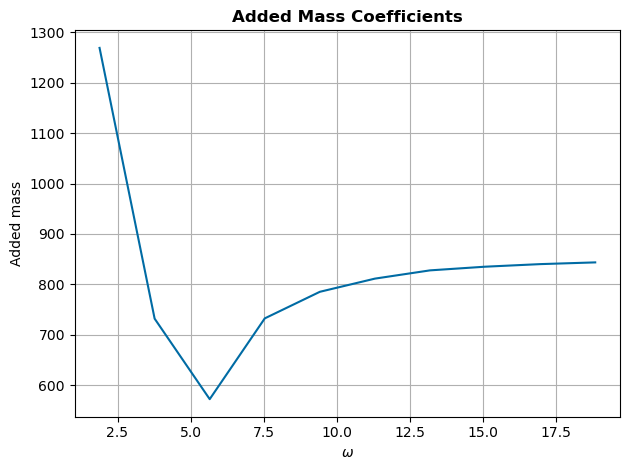

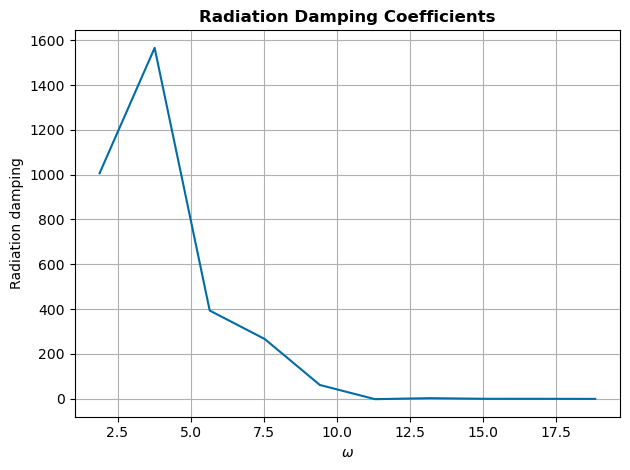

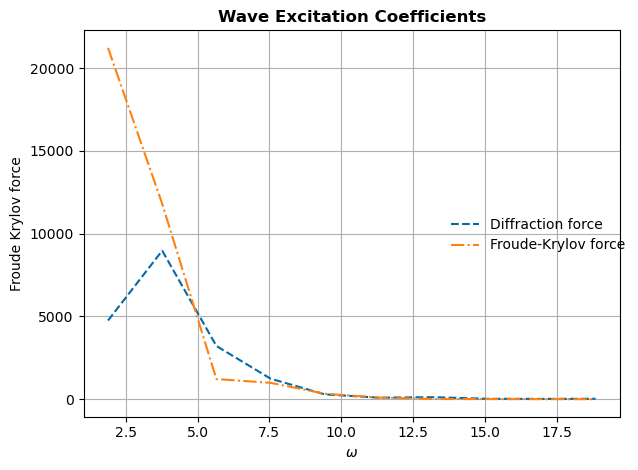

In [16]:
#wot.utilities.plot_hydrodynamic_coefficients(bem_data)
# Plots
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Heave')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Heave')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
ax_ex.grid(True)
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Heave', influenced_dof='Heave').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')
ax_am.grid(True)

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Heave', influenced_dof='Heave').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')
ax_rd.grid(True)

[08:46:33] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [52 53 54 55 56 57 60 61 63 64 65 70 74 75 76 81 82 88 90 91 92] to a minimum of 1e-06 N/(m/s)

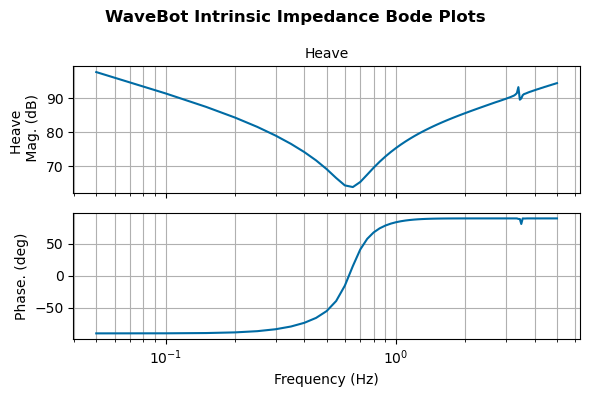

In [72]:
hd = wot.add_linear_friction(bem_data, friction = None) 
#we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

intrinsic_impedance = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(intrinsic_impedance,
                                              'WaveBot Intrinsic Impedance')

#fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC.
Data wrapped into our `PTO` class will be used to provide the additional force and constraint for our `WEC` object definition, as well as our optimization problem later.

To create an instance of the `PTO` class, we need:

* The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom.
In this case, the PTO extracts power directly from the heaving motion of the WEC, so the kinematics matrix is simply a $1 \times 1$ identity matrix.
* The definition of the PTO controller.
The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force.
However, we will be using an unstructured controller in this case, which is the default when `controller=None`.
* Any PTO impedance.
We are only interested in mechanical power for this first problem, so we will leave this empty for now.
* The non-linear power conversion loss (assumed 0% if `None`)
* The PTO system name, if desired

In [73]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now we define the PTO forcing on the WEC and the PTO constraints.
We set the maximum PTO force as 750 Newtons.
This value is chosen somewhat arbitrary to highlight different effects throughout this tutorial.
In practice, the user would need to identify their limiting component in the PTO and then compute a suitable value.
For example, if the generator drive has a maximal current $I_{max}$ of 10 A, with a generator torque constant $K_t$ of 8 Nm/A and a gear ratio $N$ of 9 rad/m, this results in a max PTO linear force of $F = N K_{t} I_{max} = 9$ rad/m $\times 8$ Nm $\times 10$ A $= 720$ N.

We will enforce the constraint at 4 times more points than the dynamics; see [Theory]((https://sandialabs.github.io/WecOptTool/theory.html)) for why this is helpful for the pseudo-spectral problem.
The constraints must be in the correct format for `scipy.optimize.minimize`, which is the solver WecOptTool uses. See the documentation for the solver [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and note the matching syntax of `ineq_cons` below.

In [74]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 750.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself!
Since we ran the BEM already, we can define the object using the `wecopttool.WEC.from_bem` function.
If we saved BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [75]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

[08:46:37] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [52 53 54 55 56 57 60 61 63 64 65 70 74 75 76 81 82 88 90 91 92] to a minimum of 1e-06 N/(m/s)

_Note: You may receive a warning regarding negative linear damping values._
_By default, WecOptTool ensures that the BEM data does not contain non-negative damping values._
_If you would like to correct the BEM solution to a different minimum damping value besides zero, you can specify_ `min_damping`.

### Objective function
The objective function is the quantity we want to optimize—in this case, the average mechanical power.
The function to compute this can be taken directly from the `PTO` object we created:

In [76]:
obj_fun = pto.mechanical_average_power

The objective function is itself a function of the optimization state `x_opt`.
The length of `x_opt`, `nstate_opt`, needs to be properly defined to successfully call `scipy.optimize.minimize`.
In other words, it should match the quantities we are interested in optimizing.
In this case, we are optimizing for the control trajectories of an unstructured PTO, which can be represented in the Fourier domain by the DC (zero frequency) component, then the real and imaginary components for each frequency.

In [77]:
nstate_opt = 2*nfreq

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients.
This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave).
Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero.

### Solve
We are now ready to solve the problem.
WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

The only required inputs for defining and solving the problem are:

1. The wave environment
2. The objective function
3. The size of the optimization state (`nstate_opt`)

Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance.
See the `scipy.optimize.minimize` documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for more details.

To help the problem converge faster, we will scale the problem before solving it (see the [Scaling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) section of the Theory documentation).
WecOptTool allows you to scale the WEC dynamics state, the optimization state, and the objective function separately.
See the `wecopttool.WEC.solve` documentation [here](https://sandialabs.github.io/WecOptTool/api_docs/wecopttool.WEC.solve.html#wecopttool-wec-solve).


Pay attention to the `Exit mode`: an exit mode of `0` indicates a successful solution.
A simple problem (linear, single degree of freedom, unconstrained, etc.) should converge in well under 100 iterations.
If you exceed this, try adjusting the scales by orders of magnitude, one at a time.

In [78]:
options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.485122883326885
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimal average mechanical power: -48.5122883326885 W


### Analyzing results
We will use two post-processing functions to obtain frequency and time domain results for the WEC and PTO responses.
The `wec.post_process` and `pto.post_process` functions both post-process the results for each wave phase realization.
The pseudo-spectral method gives continuous in time results.
To get smoother looking plots, we specify five subpoints betweeen co-location points.

In [79]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

The `pto.post_process` function returns a list of `xarray.Dataset` objects, each element of which has built-in integration with PyPlot for smart plotting with automatic titles and formatting.
We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

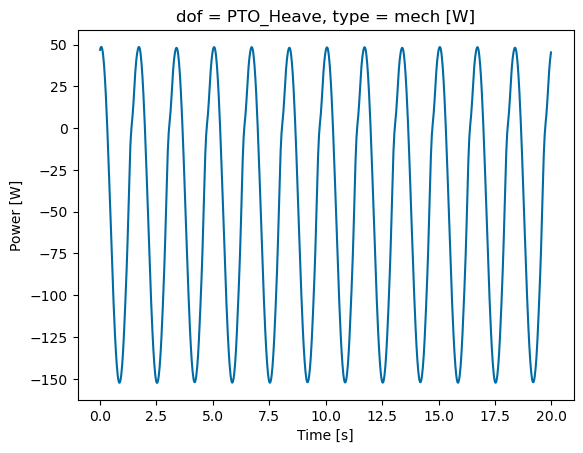

In [80]:
plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()

We could similarly plot any time or frequency domain response of the WEC or PTO by calling the specific type of response (position, velocity, force, etc.).
For example, to plot the WEC heave position and PTO force:

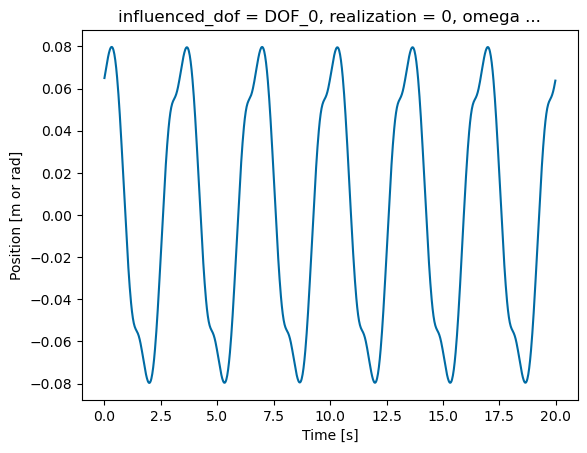

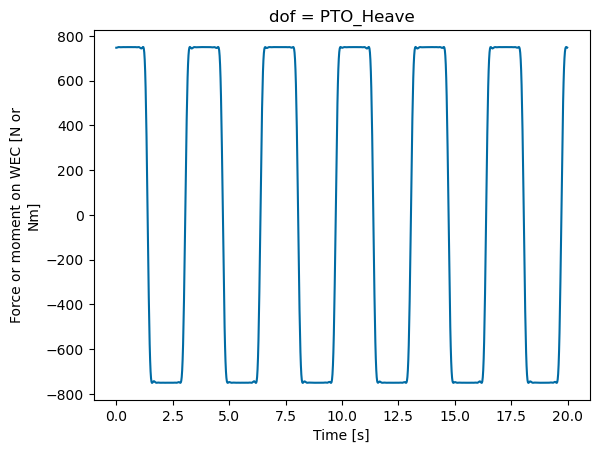

In [81]:
plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
pto_tdom[0]['force'].plot()

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`).
For example, the time domain PTO variable contains the following response:

In [82]:
pto_tdom

[<xarray.Dataset>
 Dimensions:  (time: 1000, dof: 1, type: 2)
 Coordinates:
   * time     (time) float64 0.0 0.02 0.04 0.06 0.08 ... 19.92 19.94 19.96 19.98
   * dof      (dof) <U9 'PTO_Heave'
   * type     (type) <U4 'mech' 'elec'
 Data variables:
     pos      (time, dof) float64 0.06498 0.06624 0.06754 ... 0.06256 0.06374
     vel      (time, dof) float64 0.06267 0.06411 0.06485 ... 0.05782 0.06057
     acc      (time, dof) float64 0.08876 0.0545 0.01915 ... 0.1816 0.1529 0.1217
     force    (time, dof) float64 747.2 747.3 748.0 748.9 ... 750.4 749.3 747.9
     power    (type, time, dof) float64 46.83 47.91 48.5 ... 40.87 43.32 45.3
 Attributes:
     time_created_utc:  2024-07-24 14:47:34.295553]

Lastly, we will visualize the average power at different stages and how the power flows through the system.


(<Figure size 800x400 with 1 Axes>, <Axes: >)

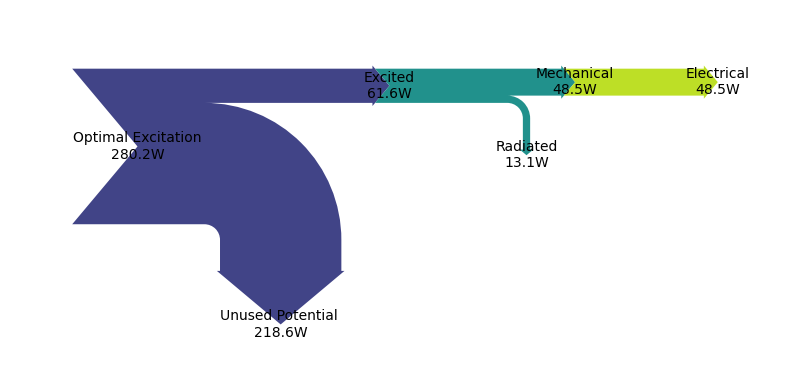

In [83]:
p_flows = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results, 
                                              waves, 
                                              intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows)


On the very left of the power flow Sankey diagram we start with the *Optimal Excitation*, which is only determined by the incident wave and the hydrodynamic damping and friction. 
In order for the actual *Excited* power to equal the *Optimal Excitation* the absorbed *Mechanical* power would need to equal the *Radiated* power (power that is radiated away from the WEC). In this case the *Unused Potential* would be zero.
In other words, you can never convert more than 50% of the incident wave energy into kinetic energy. For more information on this we refer to Johannes Falnes Book - Ocean Waves and Oscillating System, specifically Chapter 6.

However, the optimal 50% absorption is an overly optimistic goal considering that real world systems are likely constrained in their oscillation velocity amplitude and phase, due to limitations in stroke and applicable force.


The PTO force constraint used in this optimization also stopped us from absorbing the maximal potential wave energy. It is notable that we absorbed approximately 3/4 of the maximal absorbable power (*Mechanical* / (1/2 *Optimal Excitation*)), with relatively little *Radiated* power (about 1/2 of the absorbed power). To also absorb the last 1/4 of the potential wave power, we would need to increase the *Radiated* power three times!!


A more important question than "How to achieve optimal absorption?" is "How do we optimize usable output power?", i.e. *Electrical* power. For this optimization case we used a lossless PTO that has no impedance in itself. Therefore, the *Electrical* power equals the absorbed *Mechanical* power.
We'll show in the following sections that this a poor assumption and that the power flow looks fundamentally different when taking the PTO dynamics into account!!
